In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(17)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/Deep Learning Project/Project/data

/content/drive/Shareddrives/Deep Learning Project/Project/data


In [ ]:
sp = pd.read_csv("SPX_2.csv")
sp["Date"] = pd.to_datetime(sp['Date'])
sp = sp[['Date','Open','High','Low','Close']]
sp = sp.sort_values('Date', ascending=True)
start_date = pd.to_datetime('1980-01-01')
sp = sp[sp['Date'] >= start_date]
sp_df = sp[['Open','High','Low','Close']]

In [ ]:
train_size = int(len(sp) * 0.85)
train_df, test_df = sp.iloc[:train_size], sp.iloc[train_size:]

print(train_df.shape,test_df.shape)

(8755, 5) (1546, 5)


In [ ]:
train_df

,Date,Open,High,Low,Close
13022,1980-01-02,107.940002,108.430000,105.290001,105.760002
13023,1980-01-03,105.760002,106.080002,103.260002,105.220001
13024,1980-01-04,105.220001,107.080002,105.089996,106.519997
13025,1980-01-07,106.519997,107.800003,105.800003,106.809998
13026,1980-01-08,106.809998,109.290001,106.290001,108.949997
...,...,...,...,...,...
21772,2014-09-10,1988.410034,1996.660034,1982.989990,1995.689941
21773,2014-09-11,1992.849976,1997.650024,1985.930054,1997.449951
21774,2014-09-12,1996.739990,1996.739990,1980.260010,1985.540039
21775,2014-09-15,1986.040039,1987.180054,1978.479980,1984.130005


In [ ]:
train = train_df.copy()
test = test_df.copy()
train_df = train_df[['Date','Close']]
test_df = test_df[['Date','Close']]

In [ ]:
# Normalize the numerical data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

train_num_cols = train_df.columns.difference(['Date'])
test_num_cols = test_df.columns.difference(['Date'])

train_df[train_num_cols] = scaler.fit_transform(train_df[train_num_cols])
test_df[test_num_cols] = scaler.transform(test_df[test_num_cols])

<ipython-input-9-d6471220d2ff>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_num_cols] = scaler.fit_transform(train_df[train_num_cols])


In [ ]:
train_df

,Date,Close
13022,1980-01-02,0.003949
13023,1980-01-03,0.003666
13024,1980-01-04,0.004347
13025,1980-01-07,0.004499
13026,1980-01-08,0.005619
...,...,...
21772,2014-09-10,0.993705
21773,2014-09-11,0.994627
21774,2014-09-12,0.988390
21775,2014-09-15,0.987651


In [ ]:
sequence_length = 10

# Prepare sequences of data for training
def create_sequences(data, dates, sequence_length):
    sequences = []
    targets = []
    sequence_dates= []
    # seq and targets the same
    for i in range(0, len(data) - sequence_length+1, sequence_length):
        sequences.append(data[i: i + sequence_length])
        targets.append(data[i: i + sequence_length])
        sequence_dates.append(dates[i + sequence_length - 1])
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

train_data = train_df[train_num_cols].values
test_data = test_df[test_num_cols].values
train_dates = train_df['Date'].values
test_dates = test_df['Date'].values

X_train, y_train, train_seq_dates = create_sequences(train_data, train_dates, sequence_length)
X_test, y_test, test_seq_dates = create_sequences(test_data, test_dates, sequence_length)

In [ ]:
X_train.shape
#y_train.shape

(875, 10, 1)

In [ ]:

class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[1][-1], input_shape[0][-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[0][1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        assert isinstance(inputs, list)
        # encoder_output, decoder_output = inputs
        decoder_output, encoder_output = inputs

        # Applying a simple attention mechanism
        score = tf.matmul(decoder_output, self.W)
        score = tf.matmul(score, tf.transpose(encoder_output, perm=[0, 2, 1]))

        # Add bias
        score += self.b

        attention_weights = tf.nn.softmax(score, axis=-1)

        # Compute context vector as the weighted sum of encoder outputs
        context_vector = tf.matmul(attention_weights, encoder_output)

        return [context_vector, attention_weights]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0], input_shape[0][1], input_shape[0][2]), (input_shape[0][0], input_shape[0][1], input_shape[1][1])]

    def get_config(self):
        base_config = super(AttentionLayer, self).get_config()
        return base_config


# # LSTM Autoencoder architecture
# # 2 LSTM layers with 128 units in the first and 64 in the second
# def build_lstm_autoencoder(input_shape):
#     model = keras.Sequential([
#         # Encoder
#         layers.LSTM(128, activation='sigmoid', return_sequences=True, input_shape=input_shape),
#         #layers.LSTM(128, activation='sigmoid', return_sequences=True),
#         layers.LSTM(64, activation='sigmoid', return_sequences=True),
#         #Single Head attention
#         #SoftAttentionLayerV2(units=64),
#         #SoftAttentionLayer(),
#         #layers.LayerNormalization(),

#         # Latent representation
#         layers.RepeatVector(sequence_length),
#         #layers.attention

#         # Decoder
#         layers.LSTM(64, activation='sigmoid', return_sequences=True),
#         layers.LSTM(128, activation='sigmoid', return_sequences=True),
#         #layers.LSTM(256, activation='sigmoid', return_sequences=True),
#         #layers.LayerNormalization(),

#         # Multi-Head Attention
#         #layers.MultiHeadAttention(num_heads=2, key_dim=num_features, value_dim=num_features),


#         # Output layer
#         layers.TimeDistributed(layers.Dense(num_features))  # Predicting the input features (open, high, low, close)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

In [ ]:
def build_lstm_autoencoder_V2(input_shape):
    # Encoder
    inputs = keras.Input(shape=input_shape)
    encoder_lstm1 = layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoder_lstm2 = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_lstm1)

    # Latent representation
    # repeat_vector = layers.RepeatVector(sequence_length)(encoder_lstm2)

    # Decoder
    decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_lstm2)
    # Pass both decoder's hidden states and encoder's outputs to the Attention layer
    # attention_output = layers.Attention()([decoder_lstm1, encoder_lstm2])
    # attention_output, attention_scores = layers.Attention(return_attention_scores=True)([decoder_lstm1, repeat_vector])
    #attention_output = layers.Attention()([decoder_lstm1, repeat_vector])
    attention_out, attention_scores = AttentionLayer(name='attention_scores')([decoder_lstm1, decoder_lstm1])
    # Pass the attention output to the next LSTM layer
    decoder_lstm2 = layers.LSTM(128, activation='relu', return_sequences=True)(decoder_lstm1)

    # Explainable Attention weights
    # attention_out, attention_scores = AttentionLayer(name='attention_scores')([decoder_lstm2, encoder_lstm2])

    print(f'Attention score output shape is : {attention_scores.shape}')
    print(f'Attention output shape is : {attention_out.shape}')

    # Output layer
    outputs = layers.TimeDistributed(layers.Dense(num_features), name='output_sequence')(attention_out)
    print(f'models output shape is : {outputs.shape}')


    # Create the model
    model = keras.Model(inputs=inputs, outputs=[outputs, attention_scores])
    model.compile(optimizer='adam', loss={'output_sequence': 'mse', 'attention_scores': None},
    metrics={'output_sequence': 'mse'})
    return model

# Build the model
num_features = 1
input_shape = (sequence_length, num_features)
print(f'sequence length is {input_shape}')
model = build_lstm_autoencoder_V2(input_shape)

model.summary()

sequence length is (10, 1)


Attention score output shape is : (None, 10, 10)
Attention output shape is : (None, 10, 64)
models output shape is : (None, 10, 1)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm_12 (LSTM)              (None, 10, 128)              66560     ['input_4[0][0]']             
                                                                                                  
 lstm_13 (LSTM)              (None, 10, 64)               49408     ['lstm_12[0][0]']             
                                                                                                  
 lstm_14 (LSTM)              (None, 10, 64)               33

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model

# class AttentionLayer_basic(layers.Layer):
#     def __init__(self):
#         super(AttentionLayer, self).__init__()

#     def call(self, decoder_output, encoder_output):
#         # Compute attention scores here based on decoder_output and encoder_output
#         # Return the context vector or weighted sum using the attention scores

#         # Example computation (adjust as needed)
#         attention_scores = tf.matmul(decoder_output, encoder_output, transpose_b=True)
#         attention_weights = tf.nn.softmax(attention_scores, axis=-1)
#         context_vector = tf.matmul(attention_weights, encoder_output)
#         return context_vector, attention_weights

# # Define your model architecture
# def build_model(input_shape, num_batches_decoder):
#     # Encoder
#     inputs = keras.Input(shape=input_shape)
#     encoder_lstm1 = layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
#     encoder_output = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_lstm1)

#     # Decoder
#     decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_output)
#     decoder_output = layers.LSTM(128, activation='relu', return_sequences=True)(decoder_lstm1)

#     # Attention mechanism
#     attention_layer = AttentionLayer(name='attention_scores')

#     # Tile decoder output across batches
#     decoder_output_tiled = tf.tile(tf.expand_dims(decoder_output, axis=1), [1, num_batches_decoder, 1, 1])

#     # Apply attention mechanism across all batches
#     attention_outputs = []
#     attention_weights = []
#     for i in range(num_batches_decoder):
#         context_vector, attention_weight = attention_layer(decoder_output_tiled[:, i, :, :], encoder_output)
#         attention_outputs.append(context_vector)
#         attention_weights.append(attention_weight)

#     # Concatenate attention outputs across batches
#     concatenated_attention_outputs = layers.Concatenate(axis=1)(attention_outputs)
#     concatenated_attention_weights = layers.Concatenate(axis=1)(attention_weights)

#     # Output layer
#     outputs = layers.TimeDistributed(layers.Dense(1))(concatenated_attention_outputs)

#     # Create the model
#     model = keras.Model(inputs=inputs, outputs=[outputs, concatenated_attention_weights])
#     model.compile(optimizer='adam', loss={'output_sequence': 'mse', 'attention_scores': None},
#     metrics={'output_sequence': 'mse'})
#     return model

# # Example usage
# num_features = 4
# input_shape = (sequence_length, num_features)
# num_batches_decoder = X_train.shape[0]  # Example number of batches in the decoder output

# model = build_model(input_shape, num_batches_decoder)
# #model.compile(optimizer='adam', loss='mse')
# model.summary()


In [ ]:
# training
dummy_attention_data = np.zeros((len(X_train), sequence_length, 7, 7))  # shape must match the attention scores' output
history = model.fit(X_train, [y_train, dummy_attention_data], epochs=10, batch_size=32, validation_split=0.1,shuffle=False)

Epoch 1/10
25/25 [==============================] - 6s 66ms/step - loss: 0.0673 - output_sequence_loss: 0.0673 - output_sequence_mse: 0.0673 - val_loss: 0.0143 - val_output_sequence_loss: 0.0143 - val_output_sequence_mse: 0.0143
Epoch 2/10
25/25 [==============================] - 1s 45ms/step - loss: 0.0441 - output_sequence_loss: 0.0441 - output_sequence_mse: 0.0441 - val_loss: 0.4636 - val_output_sequence_loss: 0.4636 - val_output_sequence_mse: 0.4636
Epoch 3/10
25/25 [==============================] - 1s 45ms/step - loss: 0.0180 - output_sequence_loss: 0.0180 - output_sequence_mse: 0.0180 - val_loss: 0.0247 - val_output_sequence_loss: 0.0247 - val_output_sequence_mse: 0.0247
Epoch 4/10
25/25 [==============================] - 2s 83ms/step - loss: 0.0109 - output_sequence_loss: 0.0109 - output_sequence_mse: 0.0109 - val_loss: 0.0115 - val_output_sequence_loss: 0.0115 - val_output_sequence_mse: 0.0115
Epoch 5/10
25/25 [==============================] - 2s 86ms/step - loss: 0.0074 - ou

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_weights(model_inputs, attention_scores):
    # Assume model_inputs are [batch_size, sequence_length, num_features]
    # and attention_scores are [batch_size, sequence_length, sequence_length]

    # Select a single example to plot
    example_input = model_inputs[0]  # shape: (sequence_length, num_features)
    example_attention_scores = attention_scores[0]  # shape: (sequence_length, sequence_length)

    fig, ax = plt.subplots()
    cax = ax.matshow(example_attention_scores, cmap='viridis')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + ['step {}'.format(i) for i in range(sequence_length)], rotation=90)
    ax.set_yticklabels([''] + ['step {}'.format(i) for i in range(sequence_length)])

    # Show label at every tick
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    # Show the plot
    plt.show()


In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/model_with_attention_6')

In [ ]:
#if model is None:
%cd /content/drive/Shareddrives/Deep Learning Project/Project/data
model = keras.models.load_model('saved_model/model_with_attention_6')

/content/drive/Shareddrives/Deep Learning Project/Project/data


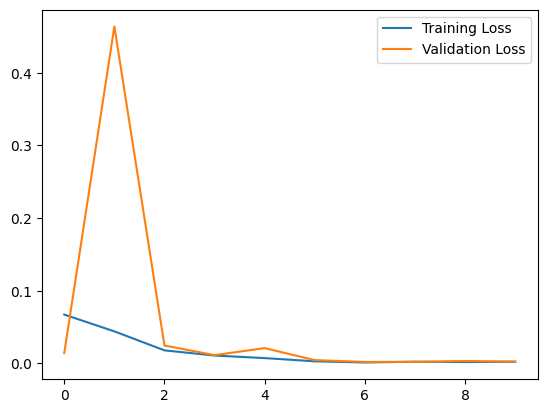

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();


28/28 [==============================] - 1s 7ms/step


<ipython-input-53-e145e93e4a61>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['step {}'.format(i) for i in range(sequence_length)], rotation=90)
<ipython-input-53-e145e93e4a61>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['step {}'.format(i) for i in range(sequence_length)])


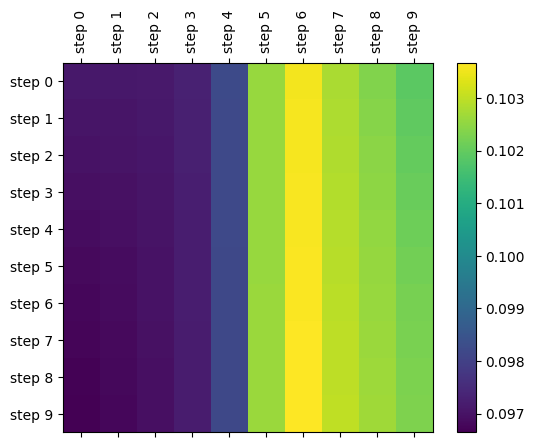

In [ ]:
X_train_pred, attention_scores = model.predict(X_train)

plot_attention_weights(X_train, attention_scores)

train_mse_loss = pd.DataFrame(np.mean(np.abs(X_train_pred[2] - X_train[2]), axis=1), columns=['Error'])

In [ ]:
attention_scores

array([[[0.09710272, 0.09708896, 0.09713209, ..., 0.10279033,
         0.10235524, 0.10189208],
        [0.09704787, 0.09704743, 0.09710253, ..., 0.10281956,
         0.1023982 , 0.10194993],
        [0.09699275, 0.09700653, 0.09707391, ..., 0.10284808,
         0.10244091, 0.10200819],
        ...,
        [0.09673153, 0.09682791, 0.09695975, ..., 0.10296848,
         0.10262317, 0.10226019],
        [0.09668771, 0.09680092, 0.09694494, ..., 0.10298592,
         0.10264879, 0.10229532],
        [0.09664594, 0.09677615, 0.09693217, ..., 0.10300165,
         0.10267161, 0.10232645]],

       [[0.09710285, 0.0970891 , 0.09713223, ..., 0.10279026,
         0.10235503, 0.10189175],
        [0.09704813, 0.09704772, 0.09710281, ..., 0.1028194 ,
         0.10239776, 0.10194919],
        [0.09699319, 0.097007  , 0.09707435, ..., 0.10284776,
         0.10244015, 0.10200695],
        ...,
        [0.09673231, 0.09682898, 0.09696099, ..., 0.1029676 ,
         0.10262098, 0.10225675],
        [0.0

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 8ms/step - loss: 0.2008 - output_sequence_loss: 0.2008 - output_sequence_mse: 0.2008


[0.20083241164684296, 0.20083241164684296, 0.20083241164684296]

5/5 [==============================] - 0s 7ms/step


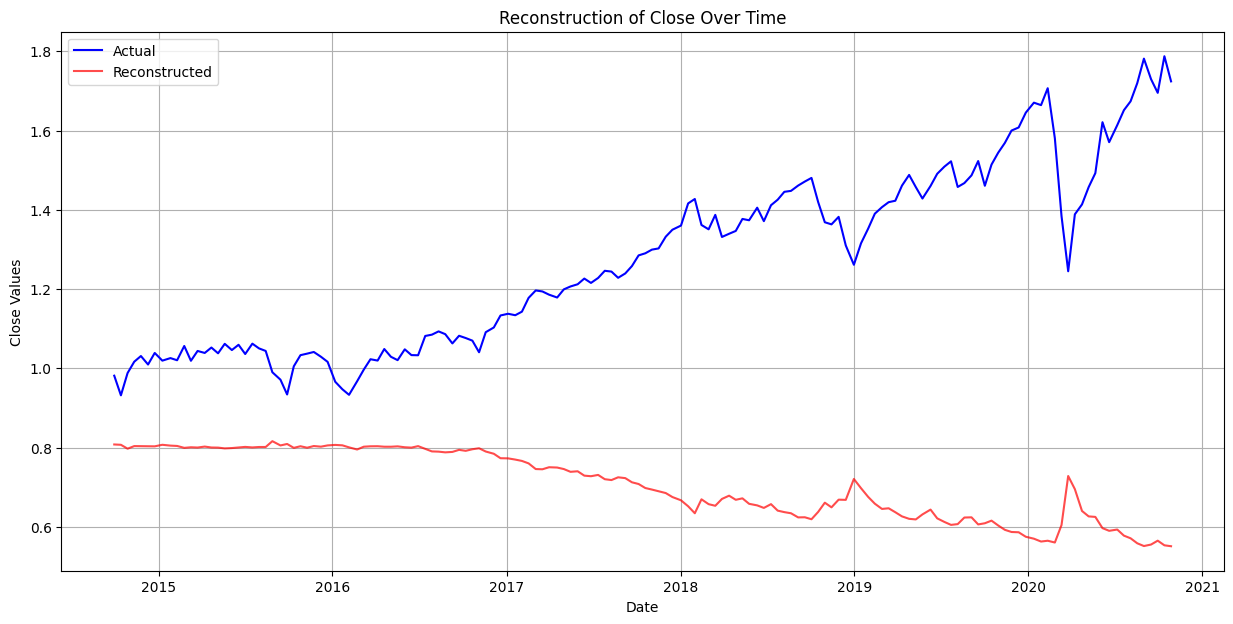

In [ ]:
def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
    plt.figure(figsize=(15, 7))
    actual_plot = actual[:, -1, feature_index]
    reconstructed_plot = reconstructed[:, -1, feature_index]
    plt.plot(dates, actual_plot, label='Actual', color='blue')
    plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
    plt.title(f'Reconstruction of {feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{feature_name} Values')
    plt.legend()
    plt.grid(True)
    plt.show()

reconstructions, scores = model.predict(X_test)

plot_reconstruction_over_time(test_seq_dates, y_test, reconstructions, feature_index=0, feature_name='Close')

In [ ]:
# Predict on train data
reconstructions, attention_scores = model.predict(X_train)
print(f'size of x_train is : {X_train.shape}')
print(f'Shape of reconstructed output is : {reconstructions.shape}')
#reconstruction_errors = np.mean(np.square(X_train - X_train), axis=(1, 2))
reconstruction_errors = np.mean((X_train - reconstructions)**2, axis=1)
# threshold
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies)[0])

54/54 [==============================] - 1s 11ms/step
size of x_train is : (1707, 7, 1)
Shape of reconstructed output is : (1707, 7, 1)
Detected anomalies: [ 949  956  958  961  965  970  972  973  974  975  976  978  979  981
  982  983  984  985  986  989  991  992  993  994  996  997  999 1000
 1003 1004 1005 1006 1008 1010 1013 1014 1015 1017 1019 1020 1021 1022
 1024 1025 1026 1027 1028 1030 1032 1033 1035 1036 1038 1039 1040 1042
 1044 1046 1047 1048 1049 1050 1051 1052 1054 1055 1056 1057 1059 1060
 1062 1065 1066 1067 1068 1069 1071 1073 1074 1075 1076 1078 1080 1082
 1084 1087]


In [ ]:
anomalies = reconstruction_errors > threshold
anomalies_indices = np.where(anomalies)[0]
print("Detected anomalies:", anomalies_indices)

Detected anomalies: [ 8863  8864  8864 ... 12644 12644 12644]


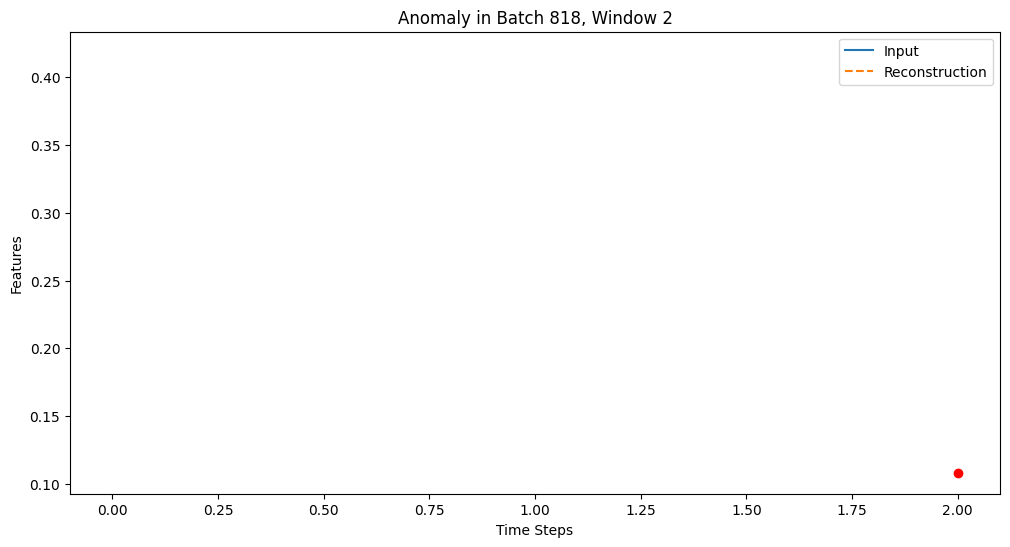

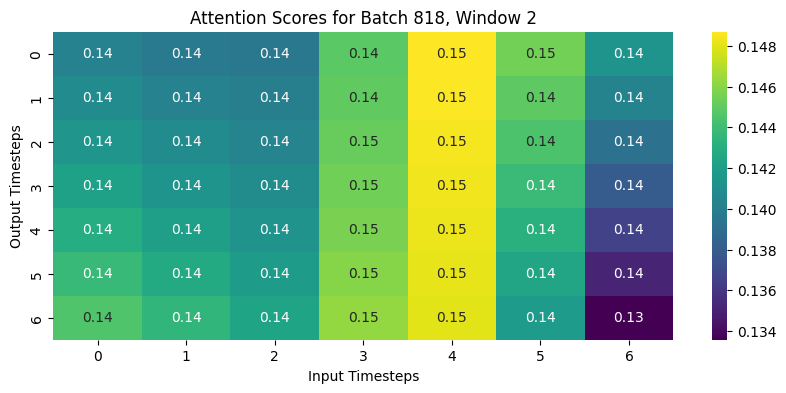

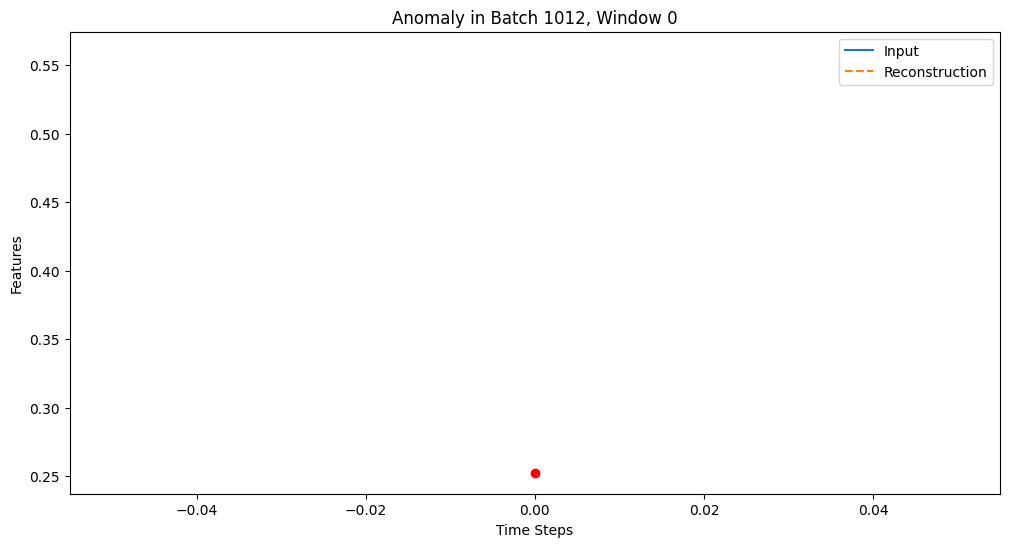

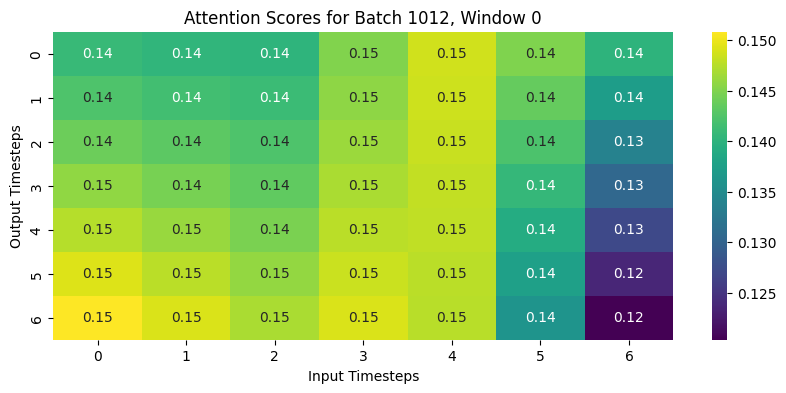

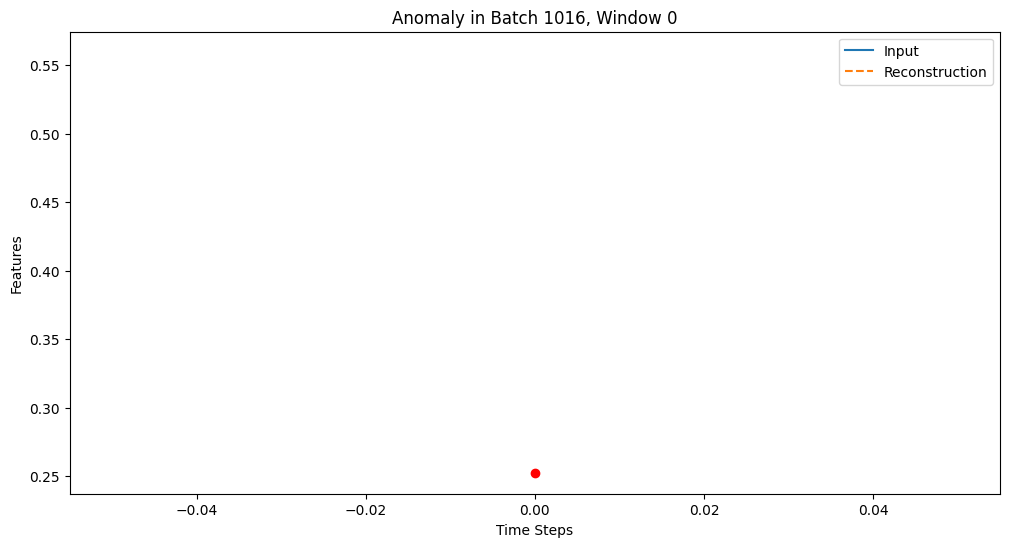

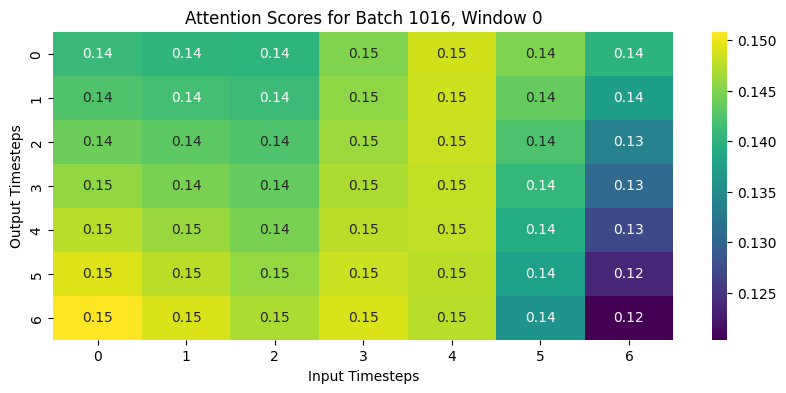

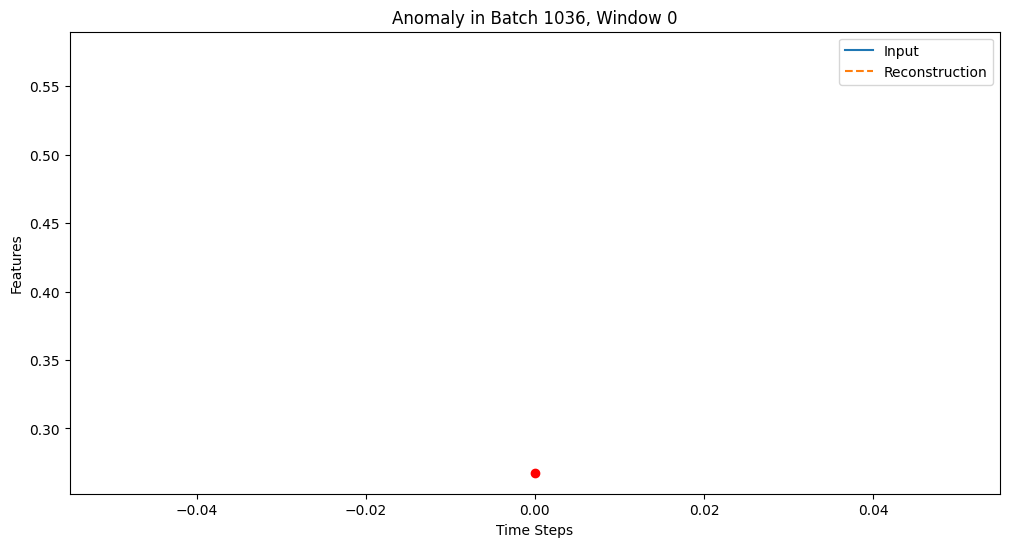

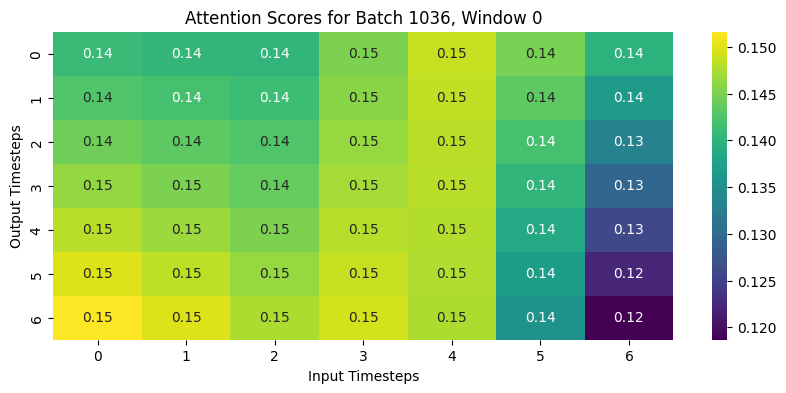

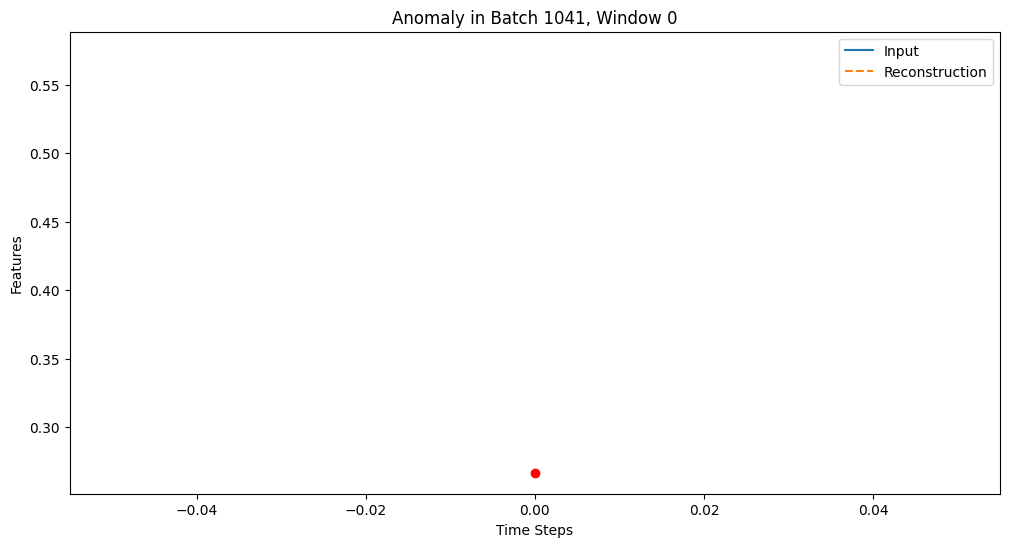

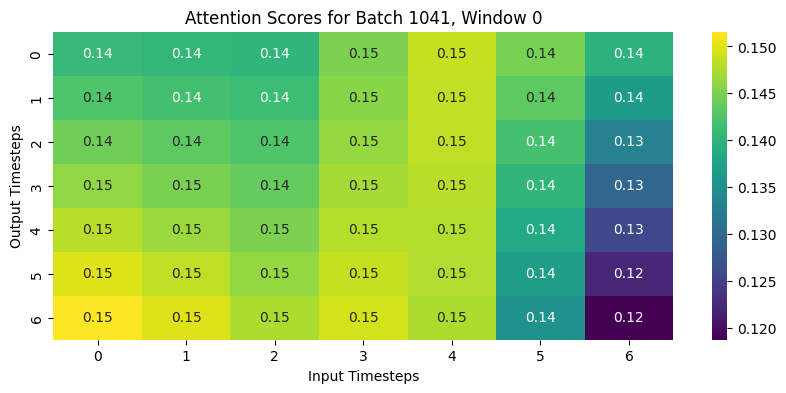

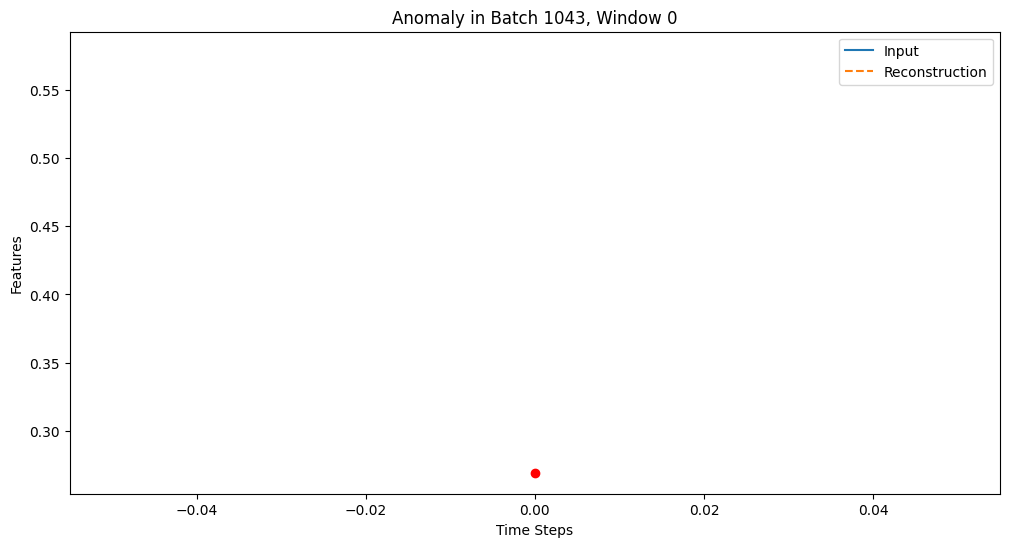

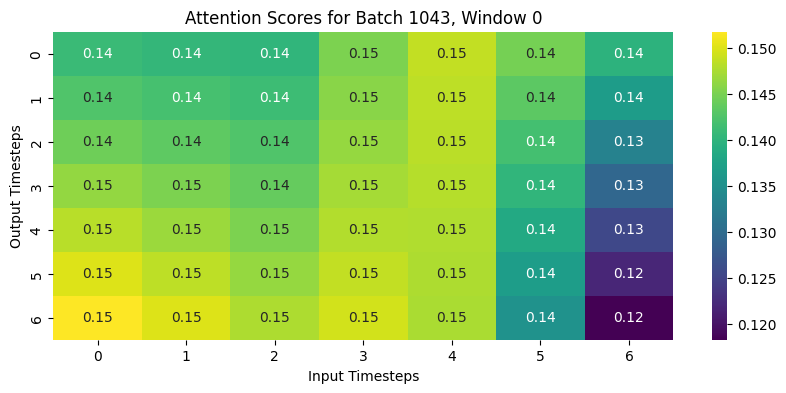

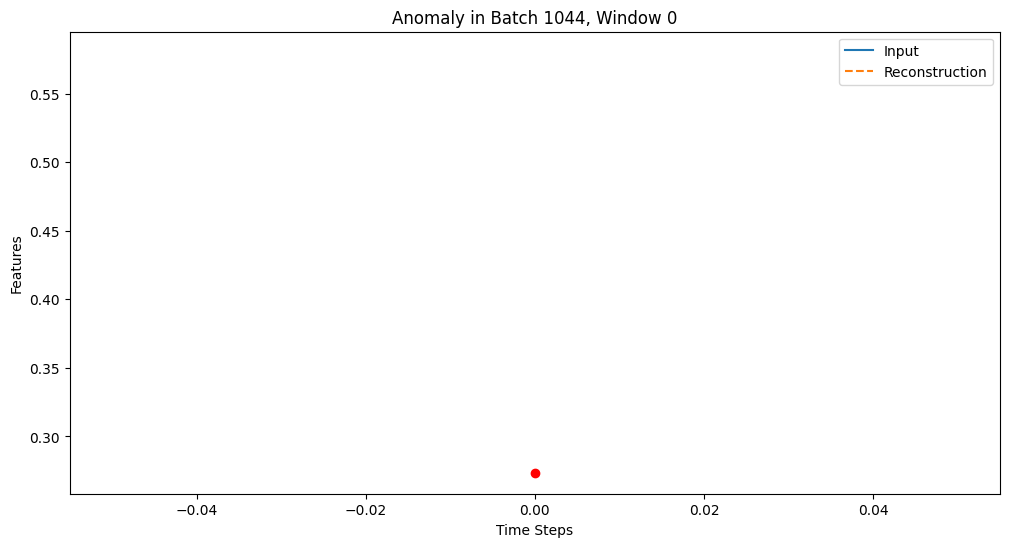

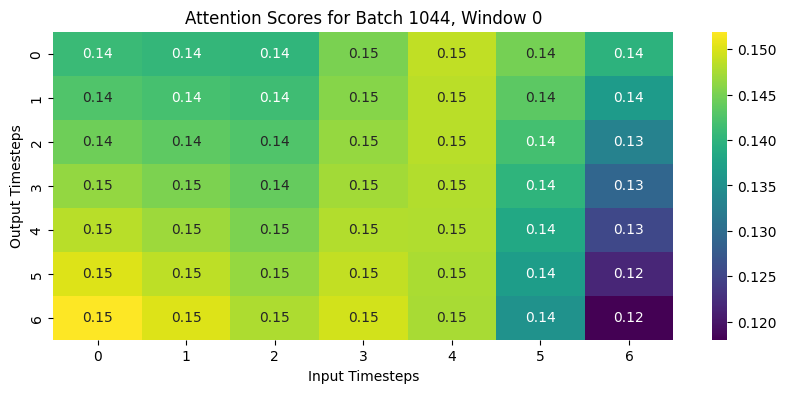

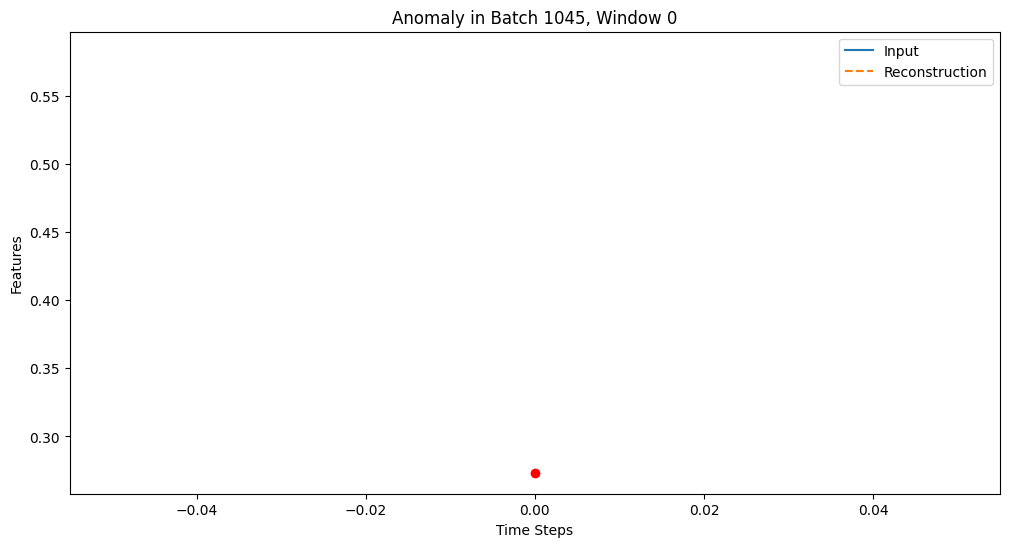

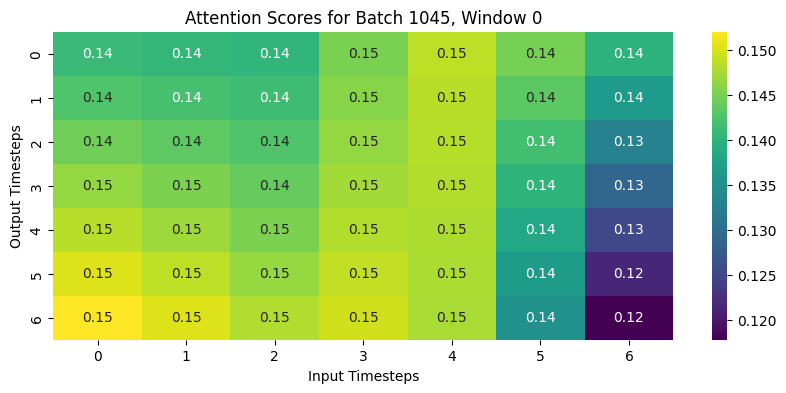

In [ ]:
def visualize_anomalies(input_sequence, reconstruction, attention_scores):
    mse = np.mean((input_sequence - reconstruction)**2, axis=2)  # Average over features
    threshold = np.percentile(mse, 95)
    anomalies = mse > threshold
    anomaly_indices = np.where(anomalies)

    num_anomalies = len(anomaly_indices[0])
    if num_anomalies > 0:
        for i in range(8):
            batch_idx, time_idx = anomaly_indices[0][i], anomaly_indices[1][i]

            plt.figure(figsize=(12, 6))
            plt.plot(input_sequence[batch_idx, time_idx, :], label='Input')
            plt.plot(reconstruction[batch_idx, time_idx, :], label='Reconstruction', linestyle='--')
            plt.scatter([time_idx], [input_sequence[batch_idx, time_idx, np.argmax(mse[batch_idx, time_idx])]], color='red')
            plt.legend()
            plt.title(f"Anomaly in Batch {batch_idx}, Window {time_idx}")
            plt.xlabel('Time Steps')
            plt.ylabel('Features')
            plt.show()

            # Attention scores for the specific time_idx across all 7 input timesteps
            plt.figure(figsize=(10, 4))
            sns.heatmap(attention_scores[batch_idx, :, :], cmap='viridis', annot=True)
            plt.title(f"Attention Scores for Batch {batch_idx}, Window {time_idx}")
            plt.xlabel('Input Timesteps')
            plt.ylabel('Output Timesteps')
            plt.show()
            #Extract attention scores for the specified point

            # attention_scores_point = attention_scores[batch_idx, time_idx, :]
            # # Plot the heatmap
            # plt.figure(figsize=(8, 6))
            # plt.imshow(attention_scores_point.reshape(1, -1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
            # plt.xlabel('Input Sequence Index')
            # plt.ylabel('Point of Interest (Batch {}, Time {})'.format(batch_idx, time_idx))
            # plt.title('Attention Scores for Point of Interest')
            # plt.colorbar()
            # plt.show()

    else:
        print("No anomalies detected based on the threshold.")

# Example usage
visualize_anomalies(X_train, reconstructions, attention_scores)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(input_sequence, reconstruction, attention_scores, title='Attention Heatmap'):
    reconstruction_mean = np.mean(reconstruction, axis=(1, 2))  # Adjust according to actual data shape
    errors = np.mean((input_sequence - reconstruction_mean)**2, axis=1)
    anomalies = errors > threshold  # make sure 'threshold' is defined or computed correctly
    anomaly_indices = np.where(anomalies)[0]

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(input_sequence)
    plt.scatter(anomaly_indices, input_sequence[anomaly_indices], color='red')  # Mark anomalies
    plt.title("Input Sequence with Anomalies Highlighted")

    plt.subplot(1, 2, 2)
    sns.heatmap(attention_scores, cmap='viridis')
    plt.title(title)
    plt.xlabel("Input Timesteps")
    plt.ylabel("Output Timesteps")
    plt.show()

    # Detailed view on first anomaly if exists
    if len(anomaly_indices) > 0:
        first_anomalous_index = anomaly_indices[0]
        plt.figure(figsize=(8, 4))
        sns.heatmap(attention_scores[first_anomalous_index:first_anomalous_index+1].reshape(-1, len(input_sequence)), cmap='viridis')
        plt.title("Attention Scores for Anomalous Sequence")
        plt.xlabel("Input Timesteps")
        plt.ylabel("Reconstruction Timestep")
        plt.show()

In [ ]:
visualize_attention(X_train, reconstructions, attention_scores)

In [ ]:
X_train_inverse = scaler.inverse_transform(X_train.reshape(-1, X_train.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# fix shaping
X_train_inverse = X_train_inverse.reshape(X_train.shape)
reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)


feature_index = 3  # 0 for 'Open', 1 for 'High', 2 for 'Low', 3 for 'Close'
time_step = 0  # 0 - sequence_length-1

plt.figure(figsize=(12, 6))
plt.plot(X_train_inverse[:, time_step, feature_index], label='X_train', color='black')
plt.plot(reconstructions_inverse[:, time_step, feature_index], label='Reconstruction', color='blue')

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title(f'Feature {feature_index} at Time Step {time_step} - Original vs Reconstruction')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

date_range = pd.date_range(start='1980-01-02', periods=len(reconstruction_errors))
anomaly_indices = np.where(anomalies)[0]

# reconstruction error over time
plt.figure(figsize=(12, 6))
plt.plot(date_range, reconstruction_errors, label='Reconstruction Error')



#  detected anomalies
plt.scatter(date_range[anomaly_indices], reconstruction_errors[anomaly_indices],
            color='red', label='Detected Anomalies', zorder=3)

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Detected Anomalies')
plt.legend()
plt.show()


In [ ]:
reconstructions = model.predict(X_test)
X_test.shape


In [ ]:

# inverse to get the non-scaled values
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# fix shaping
X_test_inverse = X_test_inverse.reshape(X_test.shape)
reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)


feature_index = 3  # 0 for 'Open', 1 for 'High', 2 for 'Low', 3 for 'Close'
time_step = 0  # 0-9

plt.figure(figsize=(12, 6))
plt.plot(X_test_inverse[:, time_step, feature_index], label='X_test', color='blue')
plt.plot(reconstructions_inverse[:, time_step, feature_index], label='Reconstruction', color='red')

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title(f'Feature {feature_index} at Time Step {time_step} - Original vs Reconstruction')
plt.legend()
plt.show()


7/7 [==============================] - 0s 34ms/step
Detected anomalies: [189 190 191 192 203 204 205 206 207 208 209]


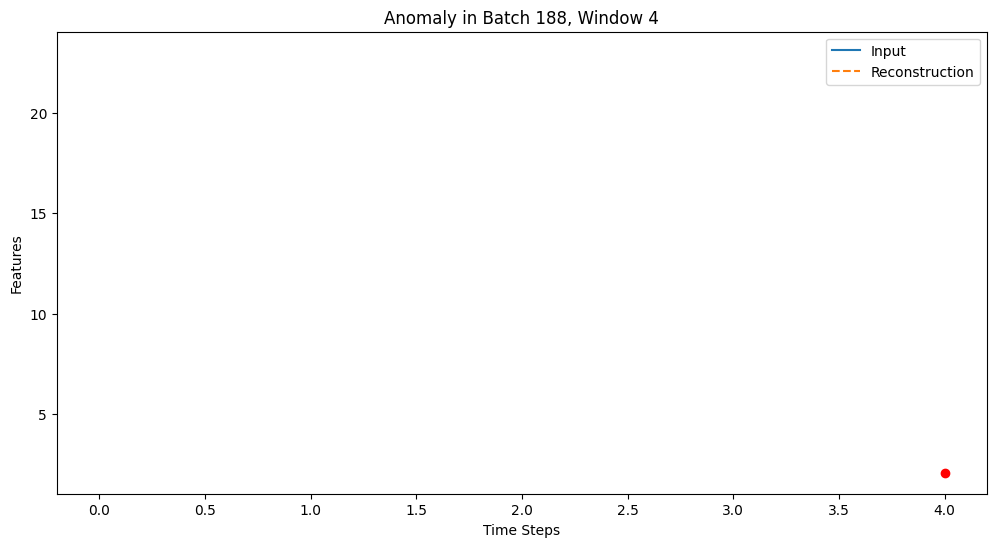

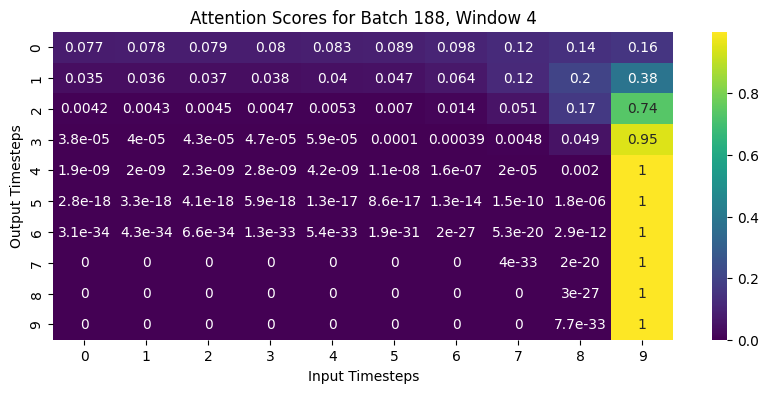

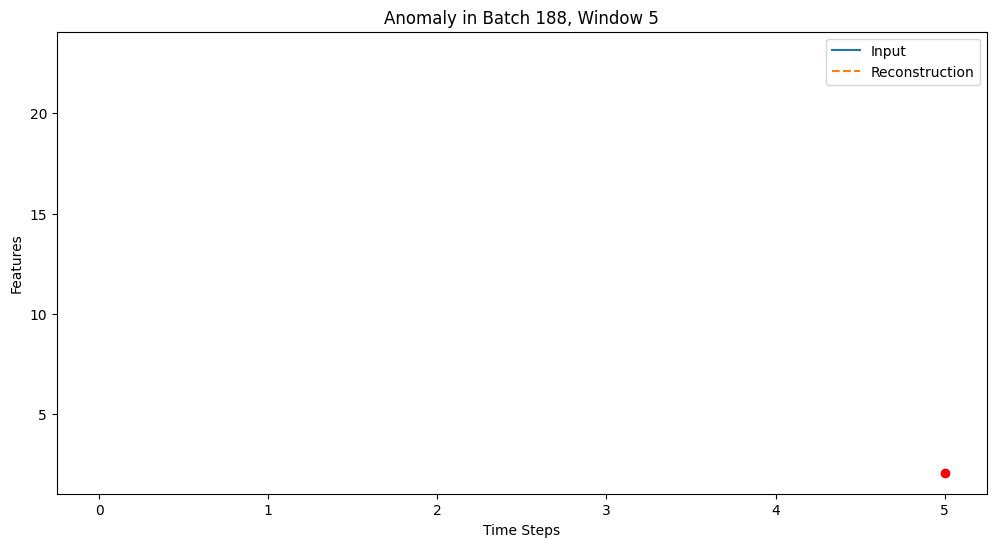

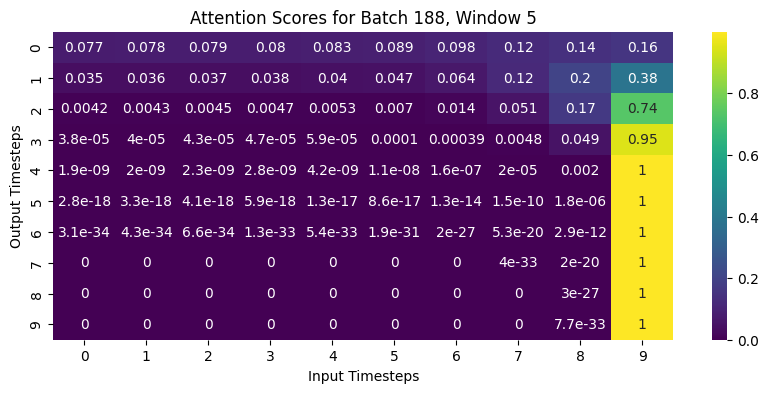

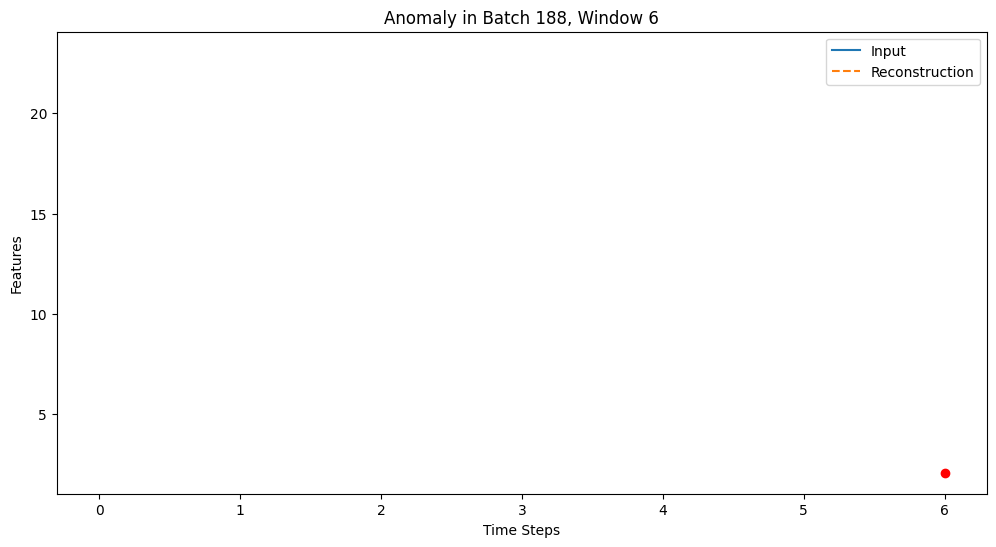

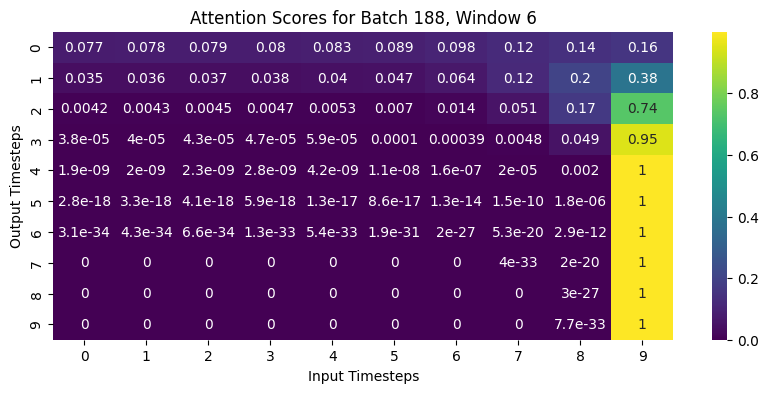

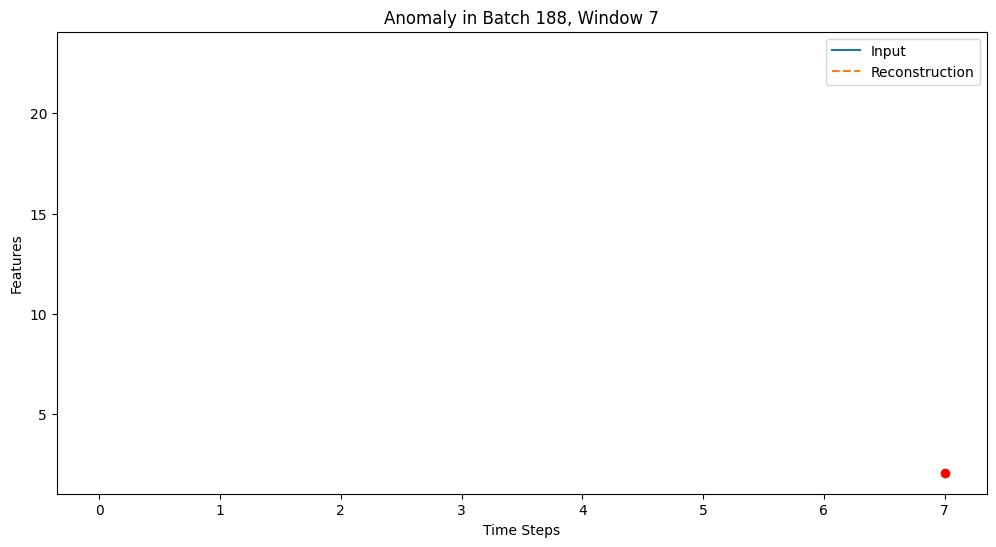

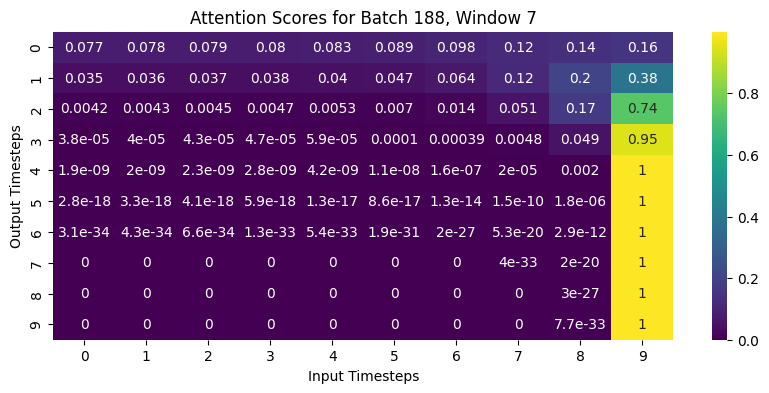

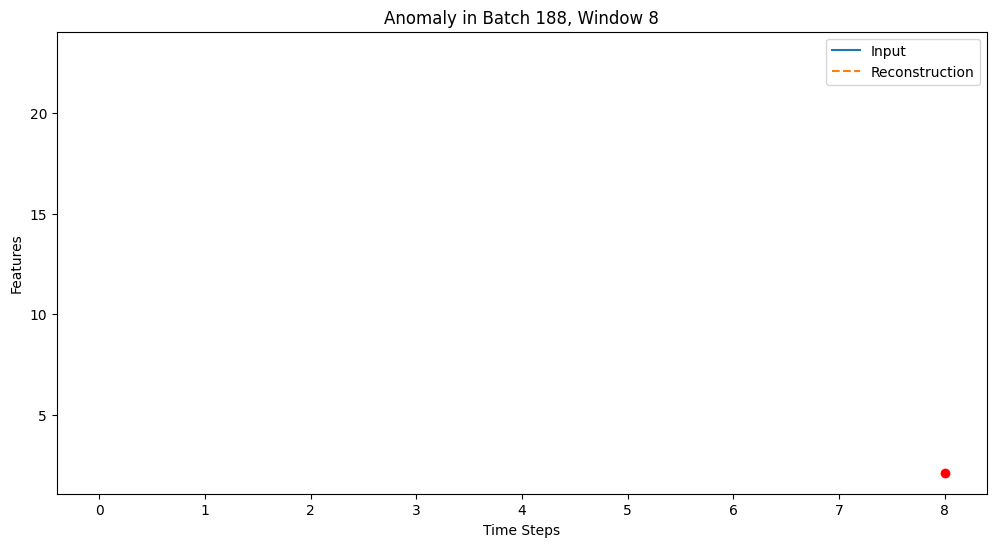

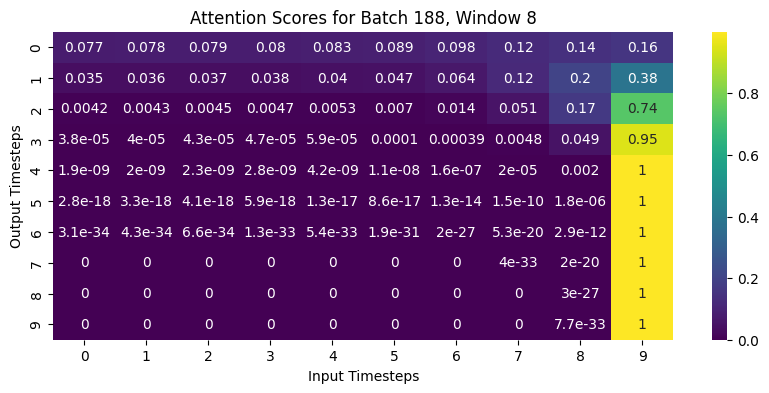

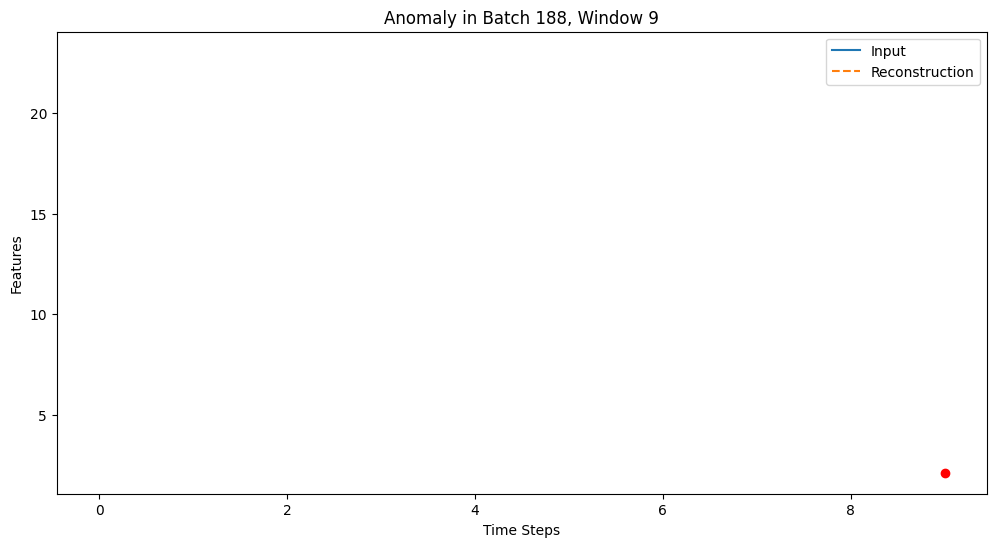

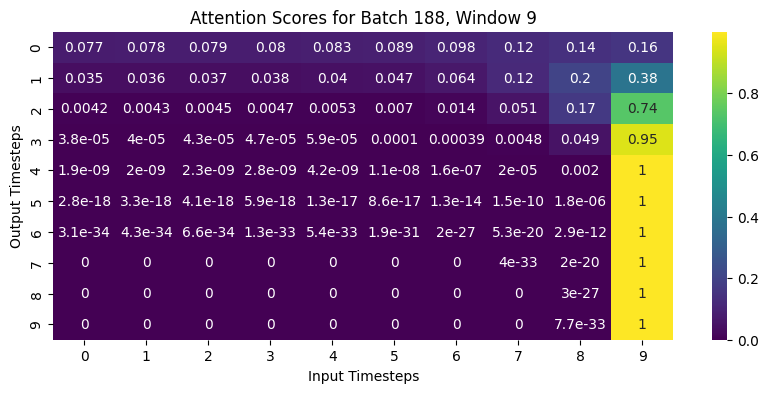

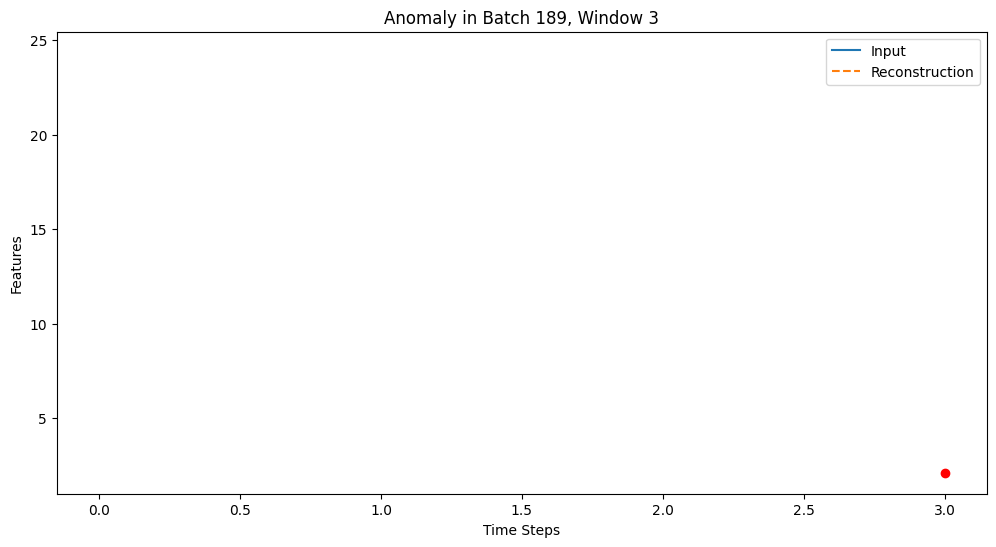

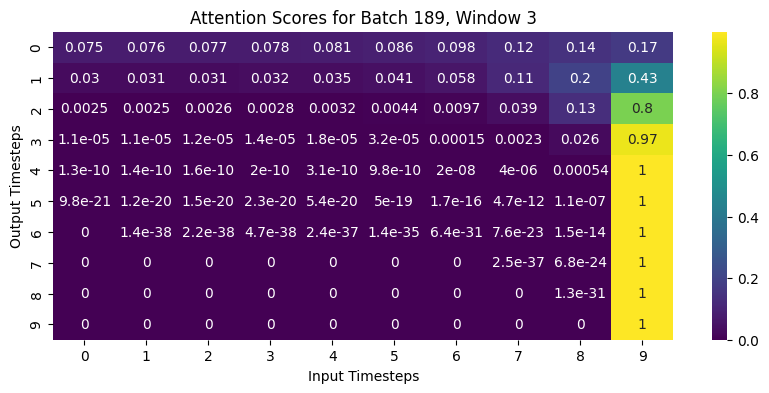

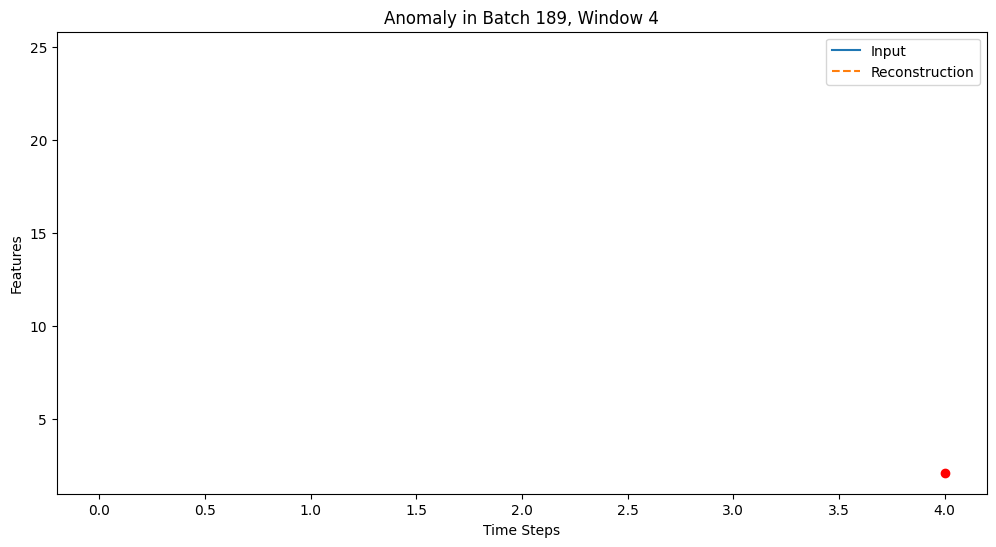

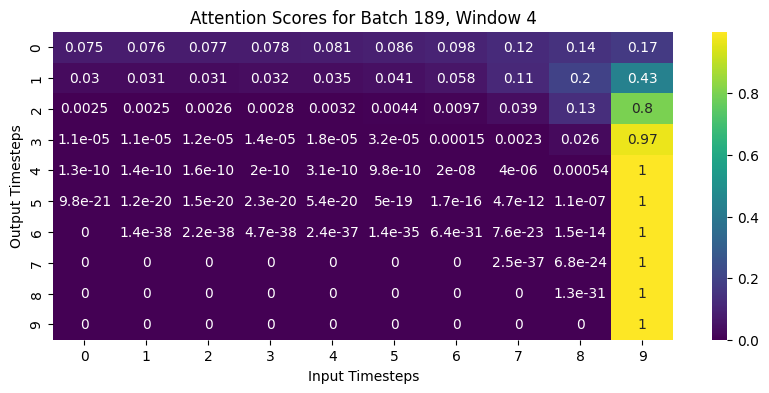

In [ ]:
  # Predict on test data
reconstructions, attention_scores = model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1, 2))

# threshold
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies)[0])
#print("Detected anomalies in:", np.where(anomalies)[1])


visualize_anomalies(X_test, reconstructions, attention_scores)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a date range for the data (modify this according to your actual date range)
date_range = pd.date_range(start='2016-10-03', periods=len(reconstruction_errors))

# Convert the boolean array of anomalies to indices
anomaly_indices = np.where(anomalies)[0]

# reconstruction error over time
plt.figure(figsize=(12, 6))
plt.plot(date_range, reconstruction_errors, label='Reconstruction Error')



#  detected anomalies
plt.scatter(date_range[anomaly_indices], reconstruction_errors[anomaly_indices],
            color='red', label='Detected Anomalies', zorder=3)

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Detected Anomalies')
plt.legend()
plt.show()


## Done


1.   LSTM Autoencoder built, trained and evaluated
  *   using 10 day windows seem to work best
  * need to plot the avg reconstruction errors based on window size

2.   Anomanlies have been detected using the reconstruction error, anything above the 95th percentile is considered an anomaly (this is a user set value)


## To-dos

1.   extract sequences around the anomalies
  *   
  *   List item


2.   List item



In [ ]:
appl_test

In [ ]:
model = tf.keras.models.load_model('saved_model/model_with_attention')

reconstructions = model.predict(appl_test)
reconstruction_errors = np.mean(np.square(appl_test - reconstructions), axis=(1, 2))

# Determine a threshold for anomaly detection (e.g., 95th percentile of reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies)[0])

In [ ]:

# inverse to get the non-scaled values
appl_test_inverse = scaler.inverse_transform(appl_test.reshape(-1, appl_test.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# fix shaping
appl_test_inverse = appl_test_inverse.reshape(appl_test.shape)
reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)


feature_index = 3  # 0 for 'Open', 1 for 'High', 2 for 'Low', 3 for 'Close'
time_step = 0  #0-9
plt.figure(figsize=(20, 6))
plt.plot(appl_test_inverse[:, time_step, feature_index], label='APPL', color='black')
plt.plot(reconstructions_inverse[:, time_step, feature_index]/10, label='Reconstruction', color='red')

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title(f'Feature {feature_index} at Time Step {time_step} - Original vs Reconstruction')
plt.legend()
plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(appl_test_inverse[:, time_step, feature_index], color='black')
ax1.set_title(f'APPL Test')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Feature Value')

ax2.plot(reconstructions_inverse[:, time_step, feature_index]/10, color='blue')
ax2.set_title(f'Reconstruction')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Feature Value')

plt.show()